In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

import warnings
warnings.filterwarnings("ignore")

2022-05-28 19:20:32.635277: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
dataset = pd.read_csv("../data/historical_btc_trend_dataset.csv")

print(dataset.head(5))

         Date  Negative  Neutral  Positive          Open        Volume  trend
0  2021-07-01    9336.0  21644.0   19892.0  35035.984375  3.783896e+10     -1
1  2021-07-02    9682.0  23126.0   17333.0  33549.601563  3.872897e+10     -1
2  2021-07-03   10251.0  22728.0   17377.0  33854.421875  2.438396e+10      0
3  2021-07-04    6030.0  14091.0    9365.0  34665.566406  2.492431e+10      1
4  2021-07-05   10562.0  23450.0   17474.0  35284.343750  2.672155e+10      0


# Data Preparation
- Data cleaning, remove missing data points
- Remove unnecessary columns
- Convert current timewindow to be relevant
- Sort data in ascending order based on date

In [3]:
dataset = dataset.dropna(axis=0, thresh=7)

# Data Split

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    dataset.drop(columns=["Date", "trend"], axis=1), 
    dataset.drop(columns=["Date", "Negative", "Neutral", "Positive", "Open", "Volume"], axis=1),
    test_size=0.20,
    shuffle=False)

In [5]:
x_train

,Negative,Neutral,Positive,Open,Volume
0,9336.0,21644.0,19892.0,35035.984375,3.783896e+10
1,9682.0,23126.0,17333.0,33549.601563,3.872897e+10
2,10251.0,22728.0,17377.0,33854.421875,2.438396e+10
3,6030.0,14091.0,9365.0,34665.566406,2.492431e+10
4,10562.0,23450.0,17474.0,35284.343750,2.672155e+10
...,...,...,...,...,...
181,13566.0,28809.0,16372.0,47623.871094,3.004923e+10
182,12595.0,27462.0,16250.0,46490.605469,2.668649e+10
183,11858.0,27096.0,16921.0,47169.371094,3.697417e+10
184,4895.0,33270.0,17838.0,46311.746094,2.458267e+10


# Normalization

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
y_train = scaler.fit_transform(y_train)
y_test = scaler.fit_transform(y_test)

In [7]:
x_train= np.reshape(x_train,(x_train.shape[0], 1, x_train.shape[1]))
x_test= np.reshape(x_test,(x_test.shape[0], 1, x_test.shape[1]))
y_train= np.reshape(y_train,(y_train.shape[0], 1, y_train.shape[1]))
y_test= np.reshape(y_test,(y_test.shape[0], 1, y_test.shape[1]))

In [8]:
y_train.shape

(186, 1, 1)

# LSTM Neural Network

In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(layers.LSTM(4, activation='relu', input_shape=(186, 5)))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("../models/0_lstm_btc_trend.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', save_weights_only=False)

batch_size=5
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), callbacks=[checkpoint1], batch_size=batch_size)

2022-05-28 19:20:33.602339: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-28 19:20:33.603074: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-28 19:20:33.641275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 19:20:33.641391: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3080 Ti computeCapability: 8.6
coreClock: 1.71GHz coreCount: 80 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 849.46GiB/s
2022-05-28 19:20:33.641409: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-28 19:20:33.642579: I tensorflow/stream_executor/platform

Epoch 1/10


2022-05-28 19:20:34.621916: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-28 19:20:34.641708: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz


 1/38 [..............................] - ETA: 27s - loss: 0.4474 - accuracy: 0.0000e+00

2022-05-28 19:20:35.195715: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


38/38 [==============================] - 1s 12ms/step - loss: 0.3507 - accuracy: 0.0520 - val_loss: 0.2030 - val_accuracy: 0.0426

Epoch 00001: val_accuracy improved from -inf to 0.04255, saving model to ../models/0_lstm_btc_trend.hdf5
Epoch 2/10
38/38 [==============================] - 0s 5ms/step - loss: 0.2424 - accuracy: 0.0618 - val_loss: 0.1458 - val_accuracy: 0.0426

Epoch 00002: val_accuracy did not improve from 0.04255
Epoch 3/10
38/38 [==============================] - 0s 5ms/step - loss: 0.1740 - accuracy: 0.0826 - val_loss: 0.1021 - val_accuracy: 0.0426

Epoch 00003: val_accuracy did not improve from 0.04255
Epoch 4/10
38/38 [==============================] - 0s 5ms/step - loss: 0.1123 - accuracy: 0.0839 - val_loss: 0.0714 - val_accuracy: 0.0426

Epoch 00004: val_accuracy did not improve from 0.04255
Epoch 5/10
38/38 [==============================] - 0s 4ms/step - loss: 0.0893 - accuracy: 0.0848 - val_loss: 0.0538 - val_accuracy: 0.0426

Epoch 00005: val_accuracy did not i

In [10]:
# Load the best model obtained during training
model = keras.models.load_model("../models/0_lstm_btc_trend.hdf5")

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

print('Model accuracy: ',test_acc)

2/2 - 0s - loss: 0.2030 - accuracy: 0.0426
Model accuracy:  0.042553190141916275


In [11]:
predictions = model.predict(x_test)

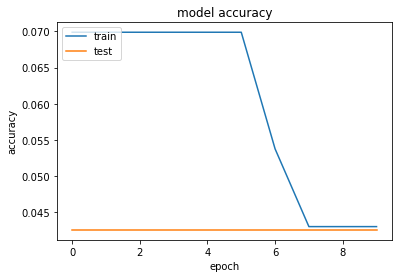

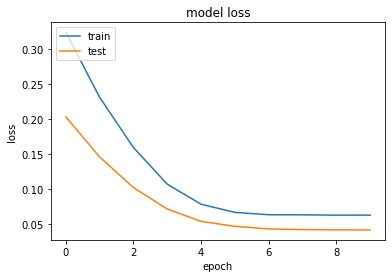

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()